In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle
import h5py
import statistics
import math
import pandas as pd
import scipy.signal

from scipy.stats import poisson
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
higgsData = pickle.load(open("higgs_100000_pt_250_500.pkl",'rb')) 
qcdData = pickle.load(open("qcd_100000_pt_250_500.pkl",'rb'))

# Lab 7: Event selection optimization

As a continuation of Lab 5, I will continue to work with low transverse momentum samples.

In this lab we will work with event selection optimization. In lab 5 we played around with the LHC to see the discrimination power of each variable.

## 1. Make a stacked histogram plot for the feature variable: mass
Evaluate expected significance without any event selection.

Use Poisson statistics for significance calculation.

Compare the exact significance to the approximation ${N_{Higgs}} / \sqrt{N_{QCD}}$. If they are equivalent, explain your findings.

#### First, let's plot the distribution of the data with respect to mass for both the Higgs and the QCD signals.

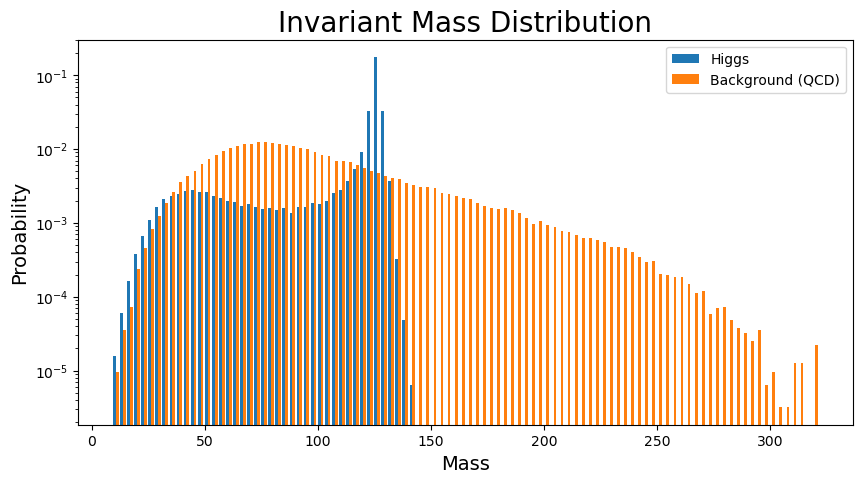

In [3]:
pt = plt.hist([higgsData['mass'], qcdData['mass']], bins = 100, density= True)
plt.title('Invariant Mass Distribution', size = 20)
plt.ylabel('Probability', size = 14)
plt.xlabel('Mass', size = 14)
plt.legend(['Higgs', 'Background (QCD)'])
plt.yscale('log') 

#### Now, let us calculate the expected significance without any event selection using Poisson statistics.

In [4]:
# expected yields given in dataset
N_higgs = 100
N_qcd = 20000
exp_sig = stats.norm.ppf(stats.poisson.cdf(N_higgs + N_qcd, N_qcd))
print(exp_sig)

sig = 100/np.sqrt(20000)
print(sig)

comp = exp_sig - sig
print("The difference between the approximation and our calculation is: " + str(comp))

0.7112259282313185
0.7071067811865475
The difference between the approximation and our calculation is: 0.00411914704477101


#### The difference between the calculations is very small! It's of the order of magnitude $10^{-3}$.

## 2. Identify mass cuts to optimize the expected significance.

Try different mass cuts systematically.

Evaluate expected significance for each set of mass cuts.

Identify the set of mass cuts which give you the highest significance.

#### The process

Let us not forget the process and purpose of these cuts.
This is an iterative process. At each step:

1) Try a mass cut.
2) Calculate the Poisson significance, and see if the significance has improved from the previous step.
3) If not, do not keep cuts. If yes, keep.

We repeat these steps as desired, to maximize significance of data.
We must be careful not to make cuts that reduce the whole set of data too much.

#### We are going to try different ranges of mass cuts. The easiest first choice would be to remove all data outside the range of Higgs data.

In [5]:
higgsMassMax = higgsData['mass'].max()
higgsMassMin = higgsData['mass'].min()

In [6]:
print(higgsMassMax)
print(higgsMassMin)

142.43960717193664
8.971221491285528


In [7]:
sigVal = (higgsData['mass'] > higgsMassMin) & (higgsData['mass'] < higgsMassMax)
sigCut = higgsData[sigVal]

bkgdVal = (qcdData['mass'] > higgsMassMin) & (qcdData['mass'] < higgsMassMax)
bkgdCut = qcdData[bkgdVal]

Here we cut out the data that was outside the range of the mass of Higgs data. Let's now compare the expected yields of this trimmed data. According to our data set, $N_{Higgs} = 100$ and $N_{qcd} = 20000$ with the original data. We didn't really cut out any of the Higgs data, so we can expect no change there.

In [8]:
nHiggs = 100
nQCD = 20000

expectedHiggsYield = nHiggs * len(sigVal)/len(higgsData)
expectedQCDYield = nQCD * len(bkgdCut)/len(qcdData)
print(expectedHiggsYield)
print(expectedQCDYield)
poissonSignificance = stats.norm.ppf(stats.poisson.cdf(expectedHiggsYield + expectedQCDYield, expectedQCDYield))
print("The significance of this mass cut is " + str(poissonSignificance))

100.0
17077.4
The significance of this mass cut is 0.766517827987654


#### Our significance grew, but only by about 0.05. Let's keep going. Looking at the distributions of both the Higgs data and the QCD data above, let's try and isolate the peak from the Higgs data. We can choose arbitrary values using our intuition.

In [9]:
sigVal = (higgsData['mass'] > 125) & (higgsData['mass'] < 135)
sigCut = higgsData[sigVal]

bkgdVal = (qcdData['mass'] > 125) & (qcdData['mass'] < 135)
bkgdCut = qcdData[bkgdVal]

expectedHiggsYield = nHiggs * len(sigVal)/len(higgsData)
expectedQCDYield = nQCD * len(bkgdCut)/len(qcdData)
print(expectedHiggsYield)
print(expectedQCDYield)
poissonSignificance = stats.norm.ppf(stats.poisson.cdf(expectedHiggsYield + expectedQCDYield, expectedQCDYield))
print("The significance of this mass cut is " + str(poissonSignificance))

100.0
860.6
The significance of this mass cut is 3.3480636432398985


#### This is a massive improvement. The significance grew from 0.766 to 3.35. Let's clamp the range even further. 

#### Looking at the above plot, the distribution of Higgs data falls off sharply at its larger values of invariant mass, so let's reduce our maximum value.

In [10]:
sigVal_final = (higgsData['mass'] > 125) & (higgsData['mass'] < 128)
sigCut_final = higgsData[sigVal_final]

bkgdVal_final = (qcdData['mass'] > 125) & (qcdData['mass'] < 128)
bkgdCut_final = qcdData[bkgdVal_final]

expectedHiggsYield = nHiggs * len(sigVal_final)/len(higgsData)
expectedQCDYield = nQCD * len(bkgdCut_final)/len(qcdData)
print(expectedHiggsYield)
print(expectedQCDYield)
poissonSignificance = stats.norm.ppf(stats.poisson.cdf(expectedHiggsYield + expectedQCDYield, expectedQCDYield))
print("The significance of this mass cut is " + str(poissonSignificance))

100.0
282.4
The significance of this mass cut is 5.657788571229185


#### I ended up playing around with the numbers here to get a satisfactory significance level. A significance value of 5.66 is solid. This is due to the result of cutting any data with a mass greater than 128 or lower than 125 units.

## 3. Make two sets of stacking histogram plots for the rest of the features.

Set A without any event selection:
Can you identify another feature as discriminative as mass? (i.e. equal or better significance after feature cut).

Set B with your optimal mass cuts:
Can you identify another feature to further improve your expected signifiance?

In [11]:
def plotCuts(key):
    fig,ax = plt.subplots(1,2)
    ax[0].set_title(key + ' Before Mass Cut')
    ax[0].hist(higgsData[key], bins = 100, density = 'true')
    ax[0].hist(qcdData[key], bins = 100, density = 'true')
    ax[0].set_ylabel('Probability', size = 12)
    ax[0].set_xlabel(key, size = 12)
    ax[0].legend(['Higgs', 'QCD'])
    ax[0].semilogy()

    ax[1].set_title(key + ' Post Mass Cut')
    ax[1].hist(sigCut_final[key], bins = 200, density = 'true')
    ax[1].hist(bkgdCut_final[key], bins = 200, density = 'true')
    ax[1].set_ylabel('Probability', size = 12)
    ax[1].set_xlabel(key, size = 12)
    ax[1].legend(['Higgs', 'QCD'])
    ax[1].semilogy()

In [12]:
print(higgsData.keys())

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


#### Let us plot each feature variable before and after the cut we made with respect to the invariant mass above. Then we can qualitatively see which other features are suitable for cuts. As we're the ones playing with the data, we can also make the decision to make such cuts before we take the cut with respect to mass.

##### Set A is the left column, set B is the right column.

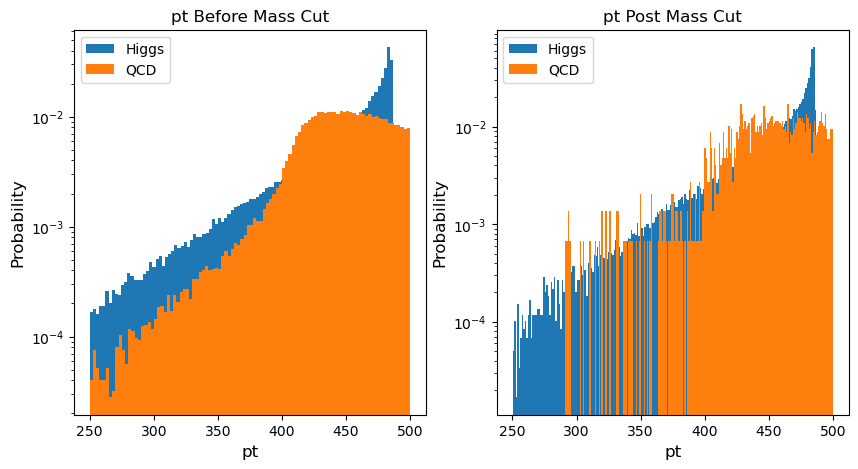

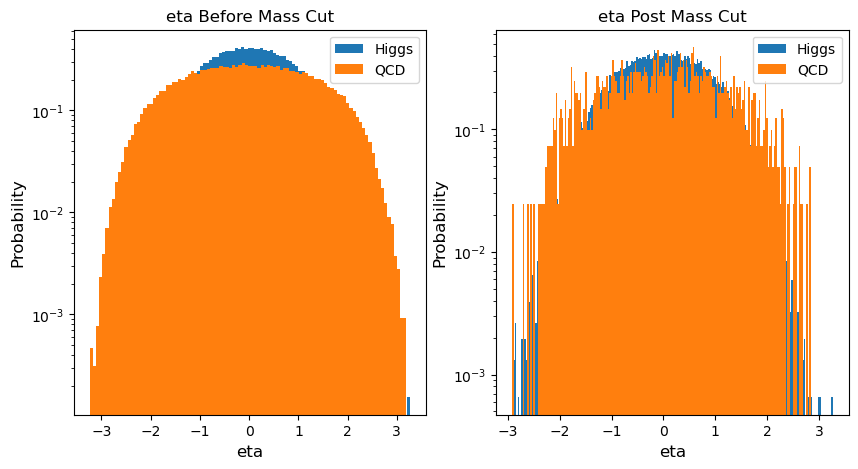

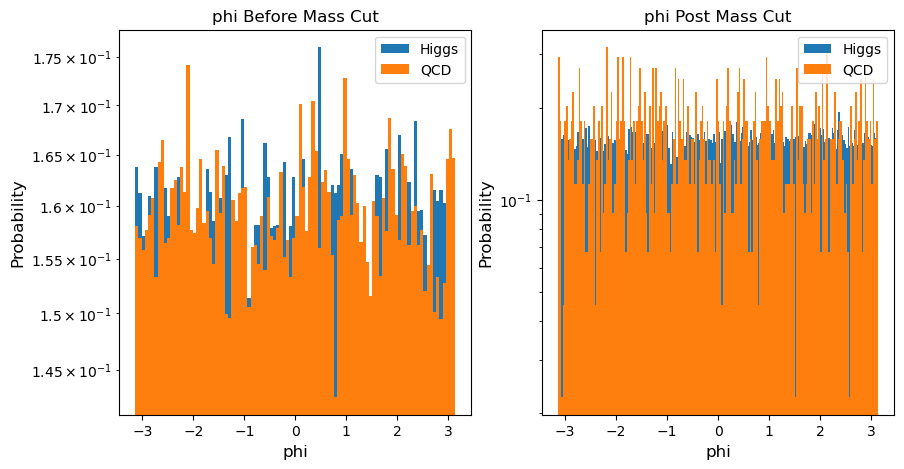

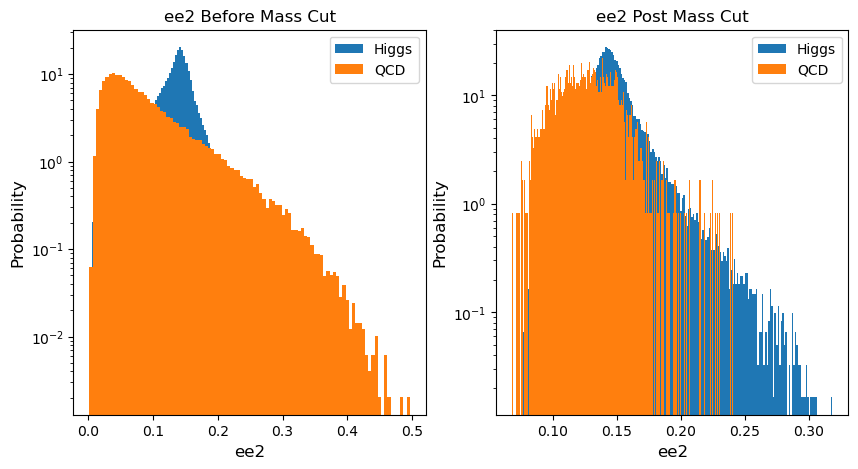

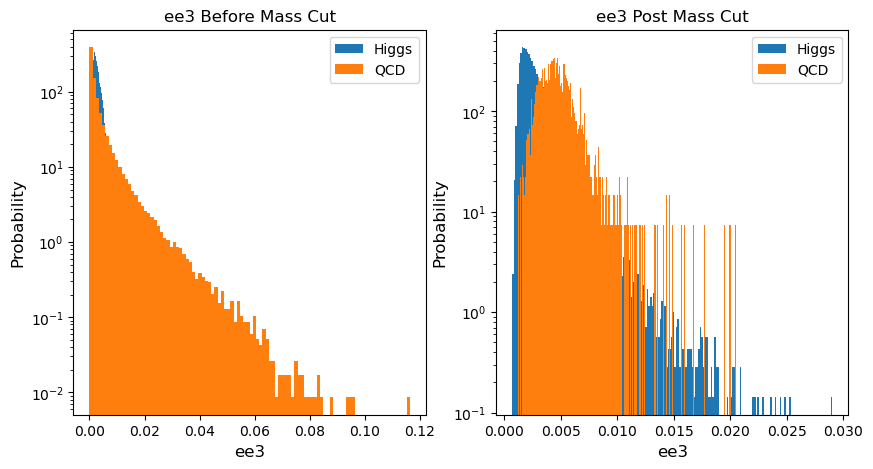

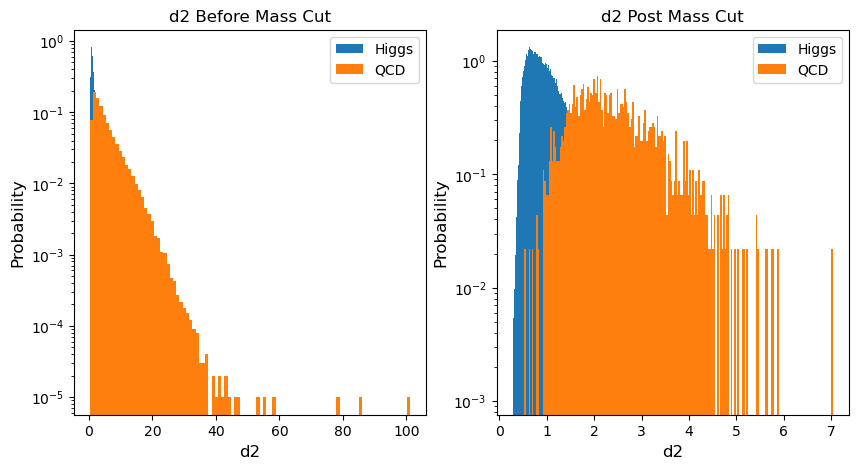

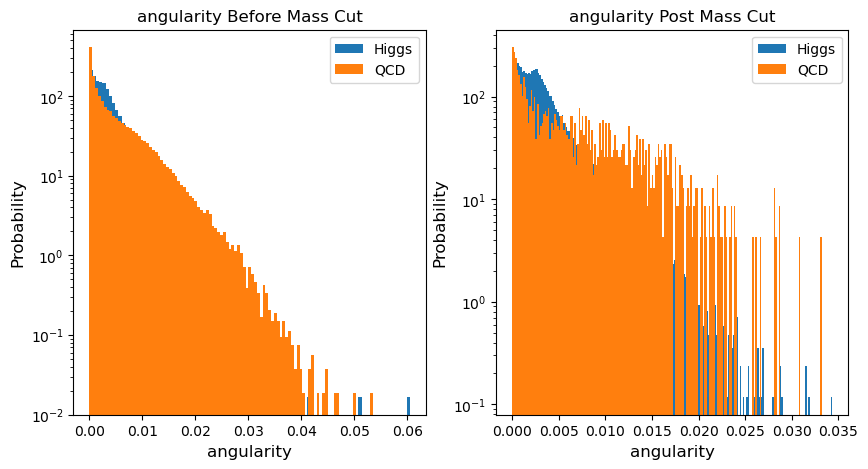

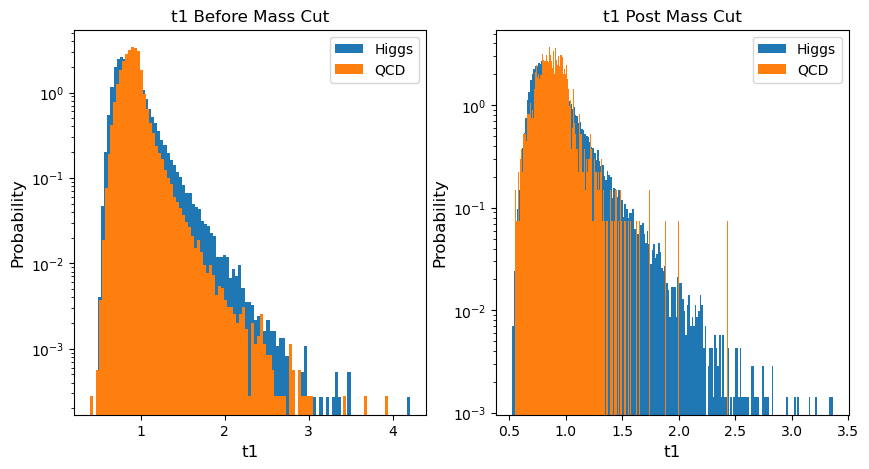

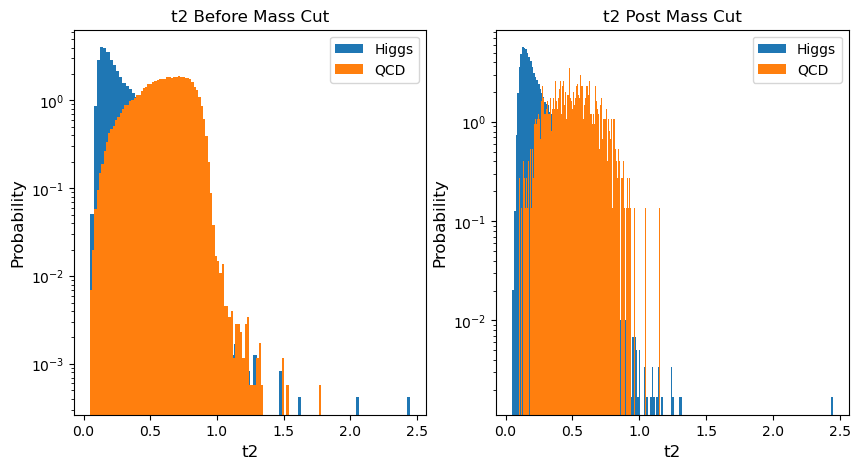

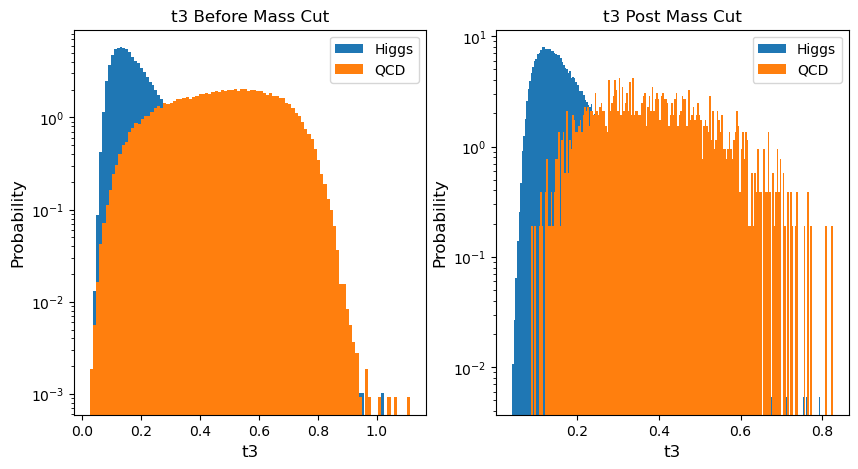

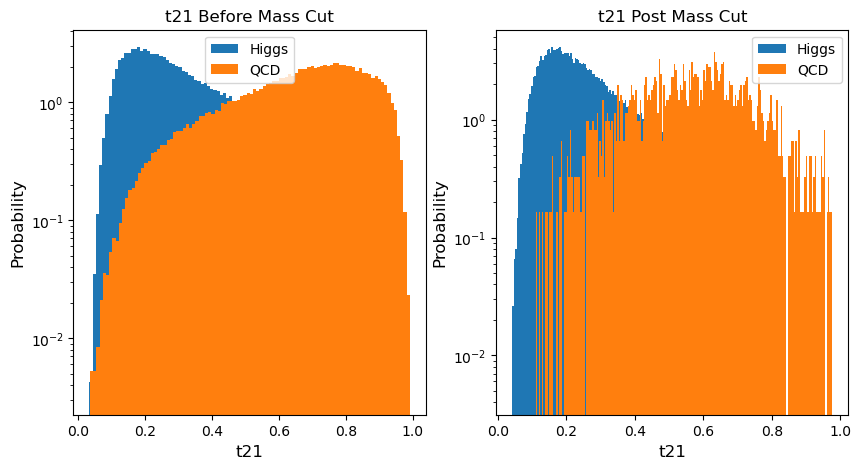

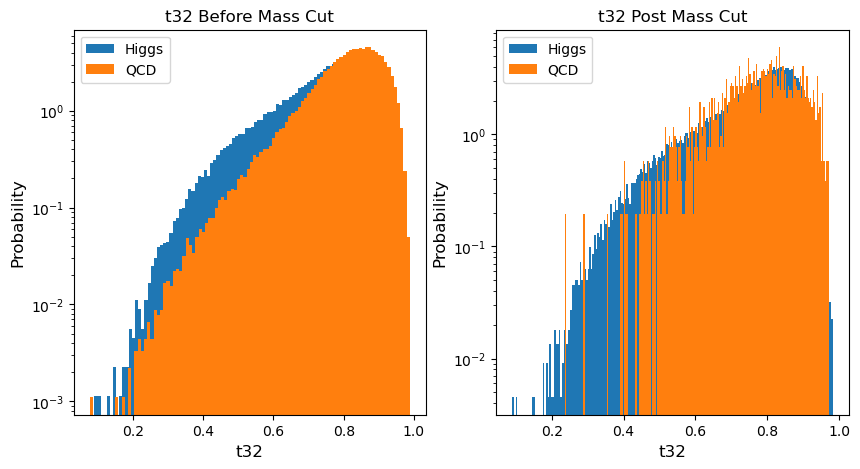

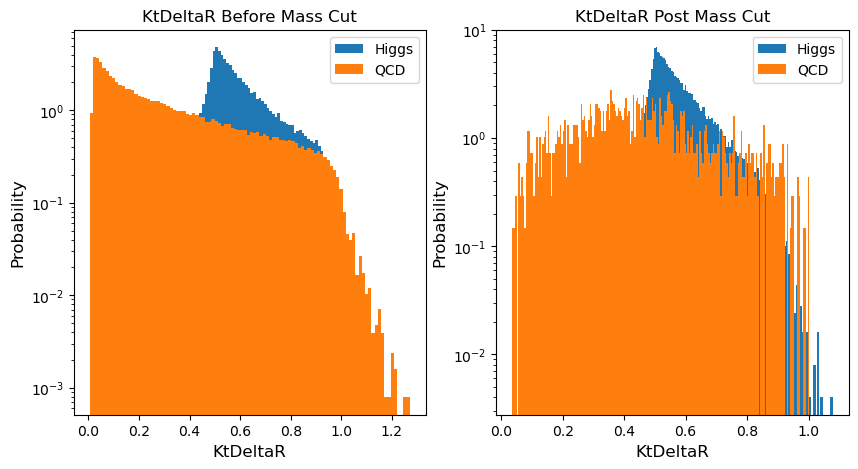

In [13]:
for key in higgsData.keys():
    if key != 'mass':
        plotCuts(key)

#### Looking at set A (the left column), from looking at the peaks alone, we can say that: ee2, t2, t3, t21 and KtDeltaR are features that provide a qualitatively useful amount of discrimination.

#### Looking at set B (the right column), after the mass cut, we can do the same process of hand picking the features. I would say the best features appear to be: t3 and t21.

## 4. Optimize event selections using multiple features (if necessary)

Our significance after the mass cut got pretty good (significance of around 5.66). So let's just try one more cut AFTER our mass cut to see if we can discriminate our Higgs signal even further.

Let's use the features we picked earlier from set B, t3 and t21, the 3-subjettiness and the 2-1 subjettiness ratio.

##### To avoid this document from getting too dense, I will tweak the values until I get a decently optimal significance improvement.

In [14]:
sigVal_postMass = (sigCut_final['t3'] > 0.05) & (sigCut_final['t3'] < 0.15)
sigCut_postMass = sigCut_final[sigVal_postMass]

bkgdVal_postMass = (bkgdCut_final['t3'] > 0.05) & (bkgdCut_final['t3'] < 0.15)
bkgdCut_postMass = bkgdCut_final[bkgdVal_postMass]

expectedHiggsYield = nHiggs * len(sigCut_postMass)/len(higgsData)
expectedQCDYield = nQCD * len(bkgdCut_postMass)/len(qcdData)
print(expectedHiggsYield)
print(expectedQCDYield)
poissonSignificance = stats.norm.ppf(stats.poisson.cdf(expectedHiggsYield + expectedQCDYield, expectedQCDYield))
print("The significance of this mass cut is " + str(poissonSignificance))

24.766
4.6
The significance of this mass cut is 7.786604801354373


#### We got a significance value of 7.79, which is very passable. 

#### We could try to do another mass cut with the 2-1 subjettiness ratio feature, and even try different combinations in different orders, however this is good enough.

# Lab 8: Psuedo-experiment data analysis

Now that we have made some suitable cuts in the previous lab with our training data, we are now going to try and apply these cuts to a different set of data (pseudo-experiment data).

## 1. High Luminosity Data

For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection.

Evaluate observed significance and compare your results to expectation.

In [15]:
highLumData = pd.read_hdf('data_highLumi_pt_250_500.h5')

#### First we have to compare the expected yields from our new pseudo-experiment data. As a reminder, from our training data, we had an expected yield of $N_{Higgs} = 100$ and $N_{qcd} = 20000$. Then we can calculate the Poisson significance.

In [16]:
print(len((highLumData['mass'])))
print(len(highLumData))

40344
40344


In [17]:
print(len(higgsData['mass']))
print(len(qcdData['mass']))

100000
100000


In [18]:
n_Higgs = 100
n_QCD = 20000

highLum_n_Higgs = (len(highLumData)/len(higgsData)) * n_Higgs
highLum_n_QCD = (len(highLumData)/len(qcdData)) * n_QCD

print(highLum_n_Higgs)
print(highLum_n_QCD)

poissonSig = stats.norm.ppf(stats.poisson.cdf(highLum_n_Higgs + highLum_n_QCD, highLum_n_QCD))
print("We calculated our Poisson significance to be: " + str(poissonSig))

40.344
8068.8
We calculated our Poisson significance to be: 0.45456947909413586


#### This is a low significance value. Let us now proceed with the cuts we devised above in Lab 7 with our pseudo-experiment data, and see if any improvements occur.

In [19]:
def plotCutsPseudo2(key, lowerBound, upperBound, currentSet):
    highLum_vals = (currentSet[key] > lowerBound) & (currentSet[key] < upperBound)
    highLum_cut = currentSet[highLum_vals]
    
    fig,ax = plt.subplots(1,2)
    ax[0].set_title('Data Before ' + key + ' Cut')
    ax[0].hist(higgsData[key], bins = 100, density = 'true')
    ax[0].hist(qcdData[key], bins = 100, density = 'true')
    ax[0].hist(currentSet[key], bins = 100, density = 'true')
    ax[0].set_ylabel('Probability', size = 12)
    ax[0].set_xlabel(key, size = 12)
    ax[0].legend(['Higgs', 'QCD', 'High Lum Data'])
    ax[0].semilogy()

    ax[1].set_title('Post ' + key + ' Cut')
    ax[1].hist(sigCut_final[key], bins = 100, density = 'true')
    ax[1].hist(bkgdCut_final[key], bins = 100, density = 'true')
    ax[1].hist(highLum_cut[key], bins = 100, density = 'true')
    ax[1].set_ylabel('Probability', size = 12)
    ax[1].set_xlabel(key, size = 12)
    ax[1].legend(['Higgs', 'QCD', 'High Lum Data'])
    ax[1].semilogy()
    
    return highLum_cut

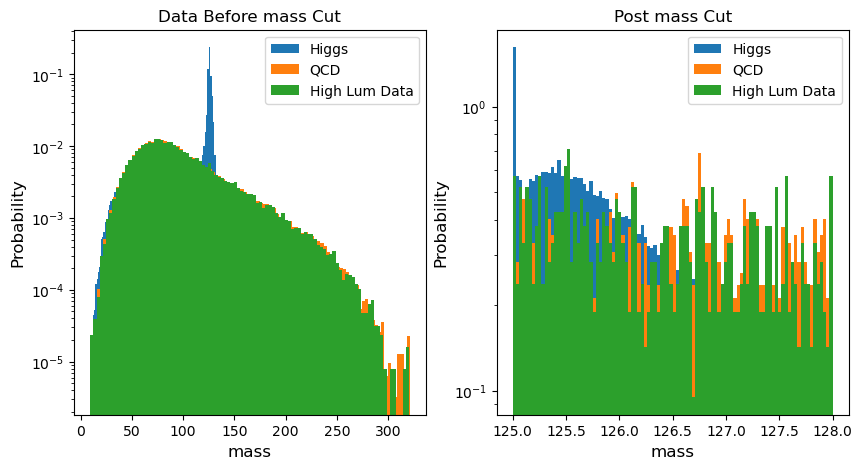

In [20]:
highLum_massCut = plotCutsPseudo2('mass', 125, 128, highLumData)

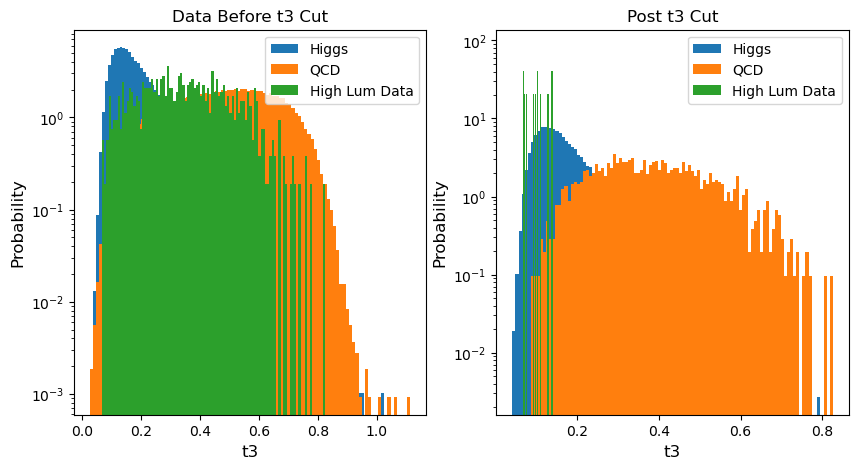

In [21]:
highLum_t3Cut = plotCutsPseudo2('t3', 0.05, 0.15, highLum_massCut)

#### Note: The left graph "Data Before t3 Cut" is after the mass cut.

#### Here we have applied both the mass cut and the t3 subjettiness cuts we derived from lab 7. Particularly, we did it by applying them in a specific order. First by taking a mass cut, then taking a t3 cut from the previous cut.

## 2. Low Luminosity Data
For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection.

Evaluate observed significance and compare your results to expectation.

In [22]:
lowLumData = pd.read_hdf('data_lowLumi_pt_250_500.h5')

#### Again, let us calculate the expected significance with the low luminance data.

In [23]:
n_Higgs = 100
n_QCD = 20000

lowLum_n_Higgs = (len(lowLumData)/len(higgsData)) * n_Higgs
lowLum_n_QCD = (len(lowLumData)/len(qcdData)) * n_QCD

print(lowLum_n_Higgs)
print(lowLum_n_QCD)

poissonSig = stats.norm.ppf(stats.poisson.cdf(highLum_n_Higgs + highLum_n_QCD, highLum_n_QCD))
print("We calculated our Poisson significance to be: " + str(poissonSig))

4.06
812.0
We calculated our Poisson significance to be: 0.45456947909413586


#### The length of the low luminance set was the same. So of course, it gave us the same significance before any event selection. Let's now proceed with our cuts.

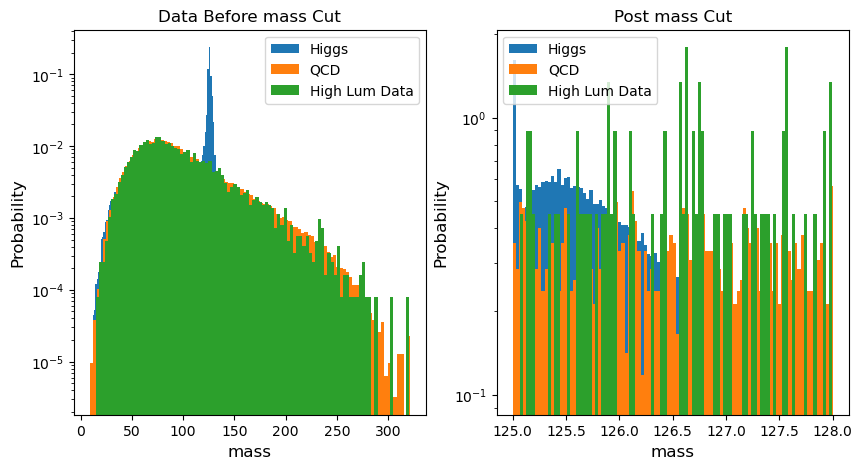

In [24]:
lowLum_massCut = plotCutsPseudo2('mass', 125, 128, lowLumData)

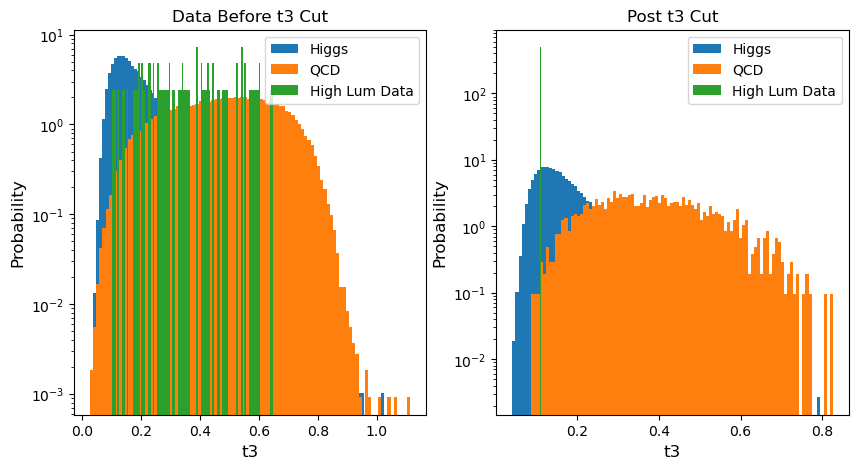

In [26]:
lowLum_t3_mass_Cut = plotCutsPseudo2('t3', 0.05, 0.15, lowLum_massCut)

#### We repeated our steps from the high luminance data.

## 3. 95% Confidence Level of signal yields

In the low luminosity data, the observed significance is less than 5$\sigma$. We will calculate the 95% confidence level upper limit of signal yield. Evaluate the __expected__ and __observed__ 95% confidence level upper limit.

We already have both the mass and the t2 cuts applied to the low luminance data. We still have to do the t3 cut with our original Higgs data from the training set in lab 7.

In [36]:
upperLimitObserved = stats.poisson.ppf(0.95, len(lowLum_t3_mass_Cut))
print("The observed upper limit is: " + str(upperLimitObserved))
sigVal_finalT2_filter = (sigCut_final['t3'] > 0.05) & (sigCut_final['t3'] < 0.15)
sigCut_final_set = sigCut_final[sigVal_finalT2_filter]

sig_expected = n_Higgs * (len(highLumData)/len(higgsData)) * (len(sigCut_final_set)/len(higgsData))
upperLimitExpected = stats.poisson.ppf(0.95, sig_expected)
print("The expected upper limit is: " + str(upperLimitExpected))


The observed upper limit is: 9.0
The expected upper limit is: 15.0


#### The expected upper limit is greater than the observed. With higher luminance data we can get a greater level of significance with our desired cuts.